In [ ]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.15.0
TF Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optimization
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
import copy
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def get_features(image, model, layers=None):
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content layer
              '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def calculate_loss(content_features, style_features, target_features):
    style_loss = content_loss = 0
    for layer in style_features:
        target_feature = target_features[layer]
        content_feature = content_features[layer]
        style_feature = style_features[layer]

        content_loss += torch.mean((target_feature - content_feature)**2)

        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_feature)
        style_loss += torch.mean((target_gram - style_gram)**2) / (d * h * w)

    total_loss = content_loss * content_weight + style_loss * style_weight
    return total_loss


In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [ ]:
def load_image(image_path, transform=None, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)
    return image

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

<ipython-input-22-012b9d2dac56>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)


TypeError: Invalid shape (1, 3, 400, 320) for image data

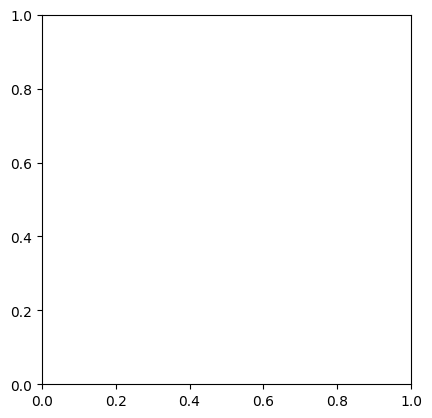

In [ ]:
content_image = load_image('/content/deer.jpg', transform)
style_image = load_image('/content/mcgill-library-y4PqRPqSako-unsplash.jpg', transform, shape=[content_image.size(2), content_image.size(3)])


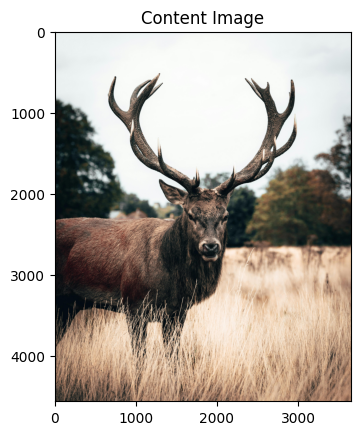

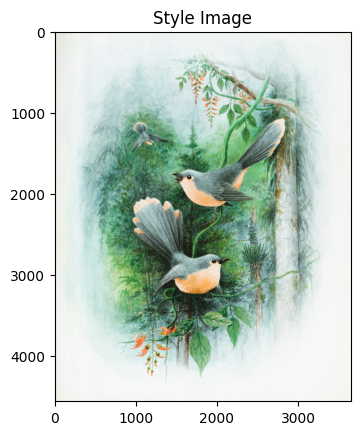

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Function to load and transform the image
def load_image(image_path, transform=None, shape=None):
    image = Image.open(image_path).convert('RGB')
    if shape is not None:
        image = image.resize((shape[1], shape[0]), Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

# Define the transformation (you can adjust these as needed)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the images
content_image_path = '/content/deer.jpg'
style_image_path = '/content/mcgill-library-y4PqRPqSako-unsplash.jpg'

content_image = load_image(content_image_path, transform)
style_image = load_image(style_image_path, transform, shape=[content_image.size(2), content_image.size(3)])

# Function to convert tensor to image and display it
def imshow(tensor, title=None):
    image = tensor.clone().detach()
    image = image.squeeze(0)  # remove the batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause to update plots

# Display the images
plt.figure()
imshow(content_image, title='Content Image')

plt.figure()
imshow(style_image, title='Style Image')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the VGG model
class VGG19Features(nn.Module):
    def __init__(self):
        super(VGG19Features, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features
        self.layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '28': 'conv5_1'
        }
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layers:
                features[self.layers[name]] = x
        return features

# Initialize the model and move it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_features = VGG19Features().to(device)

# Example usage
# Assume content_image and style_image are preprocessed and loaded tensors
content_image = content_image.to(device)
style_image = style_image.to(device)

content_features = vgg_features(content_image)
style_features = vgg_features(style_image)

# Display the extracted features for verification
for layer in content_features:
    print(f"{layer}: {content_features[layer].shape}")

for layer in style_features:
    print(f"{layer}: {style_features[layer].shape}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.8MB/s]


conv1_1: torch.Size([1, 64, 400, 320])
conv2_1: torch.Size([1, 128, 200, 160])
conv3_1: torch.Size([1, 256, 100, 80])
conv4_1: torch.Size([1, 512, 50, 40])
conv5_1: torch.Size([1, 512, 25, 20])
conv1_1: torch.Size([1, 64, 320, 400])
conv2_1: torch.Size([1, 128, 160, 200])
conv3_1: torch.Size([1, 256, 80, 100])
conv4_1: torch.Size([1, 512, 40, 50])
conv5_1: torch.Size([1, 512, 20, 25])


<ipython-input-22-012b9d2dac56>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)


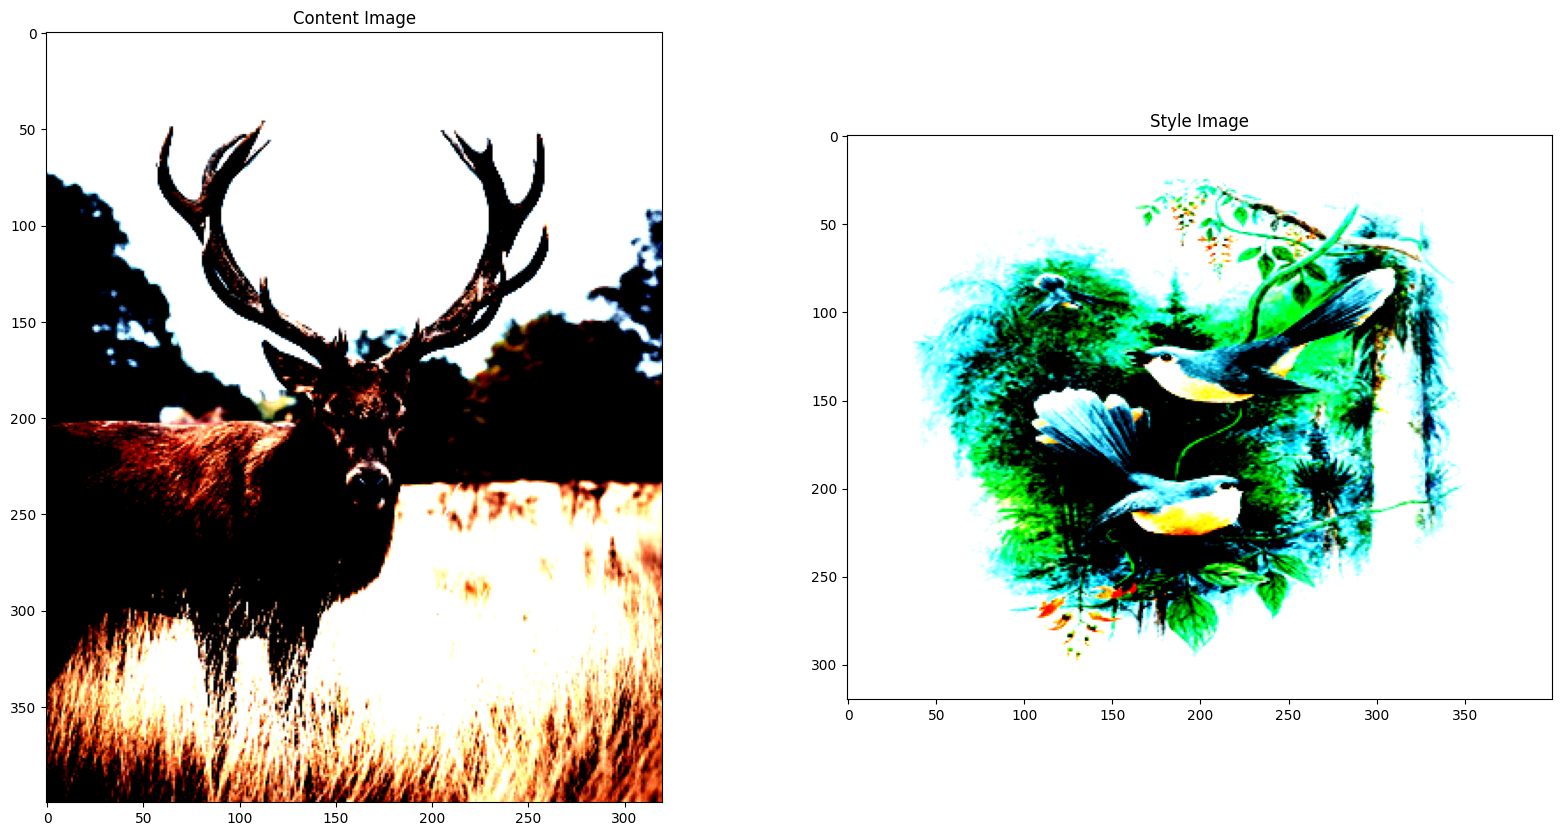

Step 400, Total loss 4237836.0


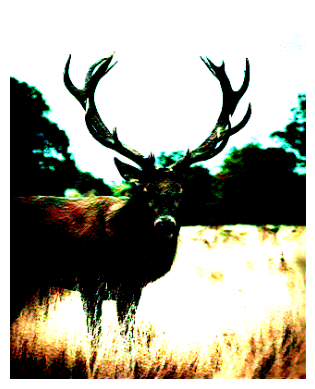

Step 800, Total loss 1967225.0


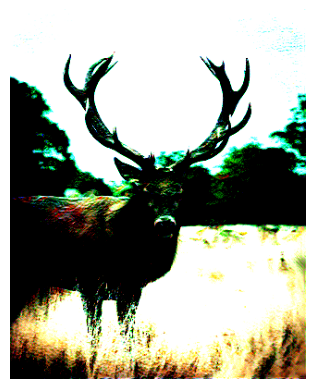

Step 1200, Total loss 1239818.25


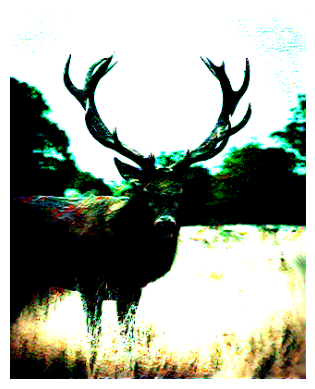

Step 1600, Total loss 897387.875


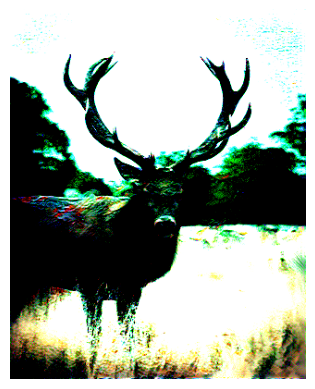

Step 2000, Total loss 692796.1875


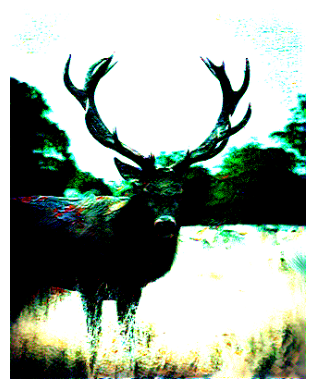

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_image(image_path, transform=None, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)
    return image

# Function to convert tensor to image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load images
content_image = load_image('/content/deer.jpg', transform)
style_image = load_image('/content/mcgill-library-y4PqRPqSako-unsplash.jpg', transform, shape=[content_image.size(2), content_image.size(3)])

# Display images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax1.set_title('Content Image')
ax2.imshow(im_convert(style_image))
ax2.set_title('Style Image')
plt.show()

# Load the VGG19 model
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
content_image = content_image.to(device)
style_image = style_image.to(device)

# Helper function to get the features of an image
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content layer
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Get features
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)

# Function to calculate the Gram Matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Get the Gram Matrices of style features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image and clone content_image
target = content_image.clone().requires_grad_(True).to(device)

# Define style and content weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

optimizer = optim.Adam([target], lr=0.003)

# Training loop
steps = 2000  # number of iterations
for step in range(1, steps+1):
    target_features = get_features(target, vgg)

    # Calculate content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Calculate style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display intermediate result
    if step % 400 == 0:
        print(f"Step {step}, Total loss {total_loss.item()}")
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()

# Save the final output
save_image(target, 'output_image.jpg')
